In [1]:
# baseball-predictor.ipynb based on hello-world-predictor
# Objective: Read the dataset, do a simple prediction for games on a given date using data prior to that date, then
#            and record some stats on how well it did.
# 
#
# 12/21/19, Alexis: Currently this "helloworld" predictor is very simple. It does the following:
#  1. Reads in the 2010 season as the baseline games dataset. It does some simple selection
#     of columns and generates a few calculated fields.
#  2. It prompts the user to specify 'game day' which are the games it is to predict.
#  3. It calculates the avg net number of runs for the home team (when playing at home) and
#     the avg net number of runs for the visiting team (when playing away).
#  4. For a given game, the predicted winner is the team with the greatest avg net runs at
#     home or away (as applicable).
#  5. The prediction is compared with the actual results that day, with % correct reported.
#
#  Proposed next steps:
#  1. Integrate Venkat's "concat" capability to combine datasets across year blocks to result
#     in a much larger dataset. Note that for development we may want to keep the dataset
#     smaller size so that it doesn't take a long time to run.
#  2. Move this out of jupyter notebook into standard Python and embed the prediction logic
#     into a function that can be called repeatedly with different dates.
#  3. Run trials with large numbers of dates to product large numbers of predictions and
#     results.
#  4. Write results to a file. Possibly generate some plot of results as a function of
#     training set window size.
#  5. Start experimenting with diffent prediction functions, initially across individual
#     factors, and then with multiple factors.
#  6. Consider a statistically meaningful regresssion analysis to select factors and training
#     set window size, by factor.
#  7. If someone has energy, consider using a web API to hit a website with current day
#     game schedule so we can predict games more recent than the dataset.
#
#
# 12/21/19, Venkat : Modified the code and included the below changes
#  1. Included the logic to combine all data files into one data frame
#  2. Included cleanup logic to clean missing data rows if any such rows exists
#
# 1/4/20, Alexis: Extend from "hello-world" to a useful predictor harness.
#  1. Implement a window to constrain the lookback period to n gamedays.
#
#
# 1/5/20, Venkat: Building the new prediction algorithm.
#                 Calculate Avg Net runs only for head-head teams, and see if it improves the forecst accuracy 




In [2]:
# Modules
import os
import csv
import pprint
import pandas as pd
import glob
import matplotlib.pyplot as plt

files = glob.glob("../datasets/Final_Data_Files/GL*.csv")
files.sort()

def reader(f):
    df = pd.read_csv(f, index_col=False, header=None)  
    df.columns = [("Col_"+str(i)) for i in range(1,df.shape[1]+1)]       

    return df

#season_df = pd.concat([reader(f) for f in files], keys=files)
season_df = pd.concat([reader(f) for f in files])


# season_df

In [3]:
season_df.shape # Useful to make sure we don't loose rows when adding column headers.

(19437, 161)

In [4]:
season_df = season_df.rename(columns={'Col_1':'Date',
                                     'Col_4':'Visiting Team',
                                     'Col_5':'Visiting League',
                                     'Col_7':'Home Team',
                                     'Col_8':'Home League',
                                     'Col_10':'Visiting Score',
                                     'Col_11':'Home Score',
                                     'Col_26':'Visiting Homerun',
                                     'Col_54':'Home Homerun',
                                     'Col_33':'Visiting Strikeout',
                                     'Col_61':'Home Strikeout',
                                      
                                     })
season_df = season_df[['Date', 'Visiting Team', 'Visiting League', 'Home Team', 'Home League',
                       'Visiting Score','Home Score','Visiting Homerun','Home Homerun','Visiting Strikeout','Home Strikeout']]
#season_df

In [5]:
# Identify incomplete rows
season_df.count()

Date                  19437
Visiting Team         19437
Visiting League       19437
Home Team             19437
Home League           19437
Visiting Score        19437
Home Score            19437
Visiting Homerun      19437
Home Homerun          19437
Visiting Strikeout    19437
Home Strikeout        19437
dtype: int64

In [6]:
# Create a column 
season_df['Home Win'] = season_df['Home Score'] > season_df['Visiting Score']
season_df['V NetRuns'] = season_df['Visiting Score'] - season_df['Home Score']
season_df['H NetRuns'] = - season_df['V NetRuns']
season_df['V AvgNetRuns'] = ""
season_df['H AvgNetRuns'] = ""
season_df['Predict Home Wins?'] = ""
season_df['Prediction Correct?'] = ""
season_df['Year'] = season_df['Date'].astype(str).str[:4]

season_df.head()

,Date,Visiting Team,Visiting League,Home Team,Home League,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Visiting Strikeout,Home Strikeout,Home Win,V NetRuns,H NetRuns,V AvgNetRuns,H AvgNetRuns,Predict Home Wins?,Prediction Correct?,Year
0,20100404,NYA,AL,BOS,AL,7,9,2,1,2,5,True,-2,2,,,,,2010
1,20100405,MIN,AL,ANA,AL,3,6,1,3,8,5,True,-3,3,,,,,2010
2,20100405,CLE,AL,CHA,AL,0,6,0,2,7,4,True,-6,6,,,,,2010
3,20100405,DET,AL,KCA,AL,8,4,0,1,9,8,False,4,-4,,,,,2010
4,20100405,SEA,AL,OAK,AL,5,3,1,0,8,6,False,2,-2,,,,,2010


In [7]:
win_rate = season_df.groupby('Home Team')['Home Win'].mean()
win_rate.head()

Home Team
ANA    0.550926
ARI    0.515432
ATL    0.554012
BAL    0.561728
BOS    0.540123
Name: Home Win, dtype: float64

In [8]:
sum_season_df = season_df.groupby(['Home Team']).sum()
sum_season_df =sum_season_df.drop('Date', axis=1)
sum_season_df.head()

,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Visiting Strikeout,Home Strikeout,Home Win,V NetRuns,H NetRuns
Home Team,,,,,,,,,
ANA,2583,2699,632,635,5117,4360,357.0,-116,116
ARI,3061,3096,727,709,5042,5174,334.0,-35,35
ATL,2600,2678,548,563,5359,4898,359.0,-78,78
BAL,2960,2971,808,922,4760,4723,364.0,-11,11
BOS,3032,3338,656,664,5250,4599,350.0,-306,306


In [9]:
sum_season_df['Win Rate'] = win_rate
sum_season_df.head()

,Visiting Score,Home Score,Visiting Homerun,Home Homerun,Visiting Strikeout,Home Strikeout,Home Win,V NetRuns,H NetRuns,Win Rate
Home Team,,,,,,,,,,
ANA,2583,2699,632,635,5117,4360,357.0,-116,116,0.550926
ARI,3061,3096,727,709,5042,5174,334.0,-35,35,0.515432
ATL,2600,2678,548,563,5359,4898,359.0,-78,78,0.554012
BAL,2960,2971,808,922,4760,4723,364.0,-11,11,0.561728
BOS,3032,3338,656,664,5250,4599,350.0,-306,306,0.540123


,Home Homerun,Win Rate
Home Homerun,1.000000,0.413422
Win Rate,0.413422,1.000000


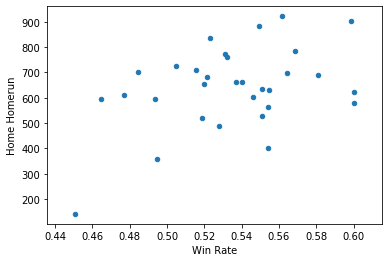

In [22]:
df = sum_season_df[["Home Homerun","Win Rate"]]
df.plot(kind='scatter',x="Win Rate", y="Home Homerun")
df.corr()
#df.pval()
#df[['Correlation_coefficent','P-value']]
#df['Correlation_coefficent'], df['P-value'] = zip(*df.T.apply(lambda x: pearsonr(x[column_values ],x[column_values ])))






,Home Homerun,Win Rate
Home Homerun,1.000000,0.413422
Win Rate,0.413422,1.000000


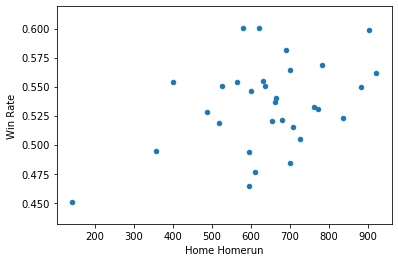

In [20]:
df = sum_season_df[["Home Homerun","Win Rate"]]
df.plot(kind='scatter',x="Home Homerun", y="Win Rate")
df.corr()


,Home Strikeout,Win Rate
Home Strikeout,1.000000,0.249299
Win Rate,0.249299,1.000000


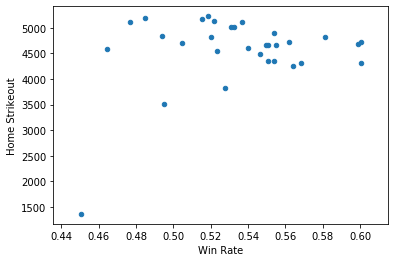

In [15]:
df = sum_season_df[["Home Strikeout","Win Rate"]]
df.plot(kind='scatter',x="Win Rate", y="Home Strikeout")
df.corr()

In [ ]:
def plotYear(year):
    grouped_year = grouped[grouped.year]

In [ ]:
# Create a dataframe of unique game days with the game ID for the first game

# season_df.head()
gamedays = pd.Series(season_df['Date'].unique())
print(gamedays.head())
print(gamedays.tail())
print(type(gamedays.iloc[0]))

def gamedays_offset(base_date, n): # returns new game date offset by n
    base_date_index = gamedays[gamedays==base_date].index[0]
    if ((n + base_date_index) < 0) or n + base_date_index >= len(gamedays):
        raise ValueError(f"Attempting to caluclate a game date outside the range of the dataset.")
        return(0)  # Out of range
    else:
        new_index = base_date_index + n
#         print(f"new_index={new_index}")
        return gamedays.iloc[new_index]

# This is a manual test of the gamedays_offset() function.
print(gamedays_offset(20120406, -100))
    

In [ ]:
# Drop all rows with missing information
season_df = season_df.dropna(how='any')
season_df.count()

In [ ]:
# Create a column 
season_df['Home Winner'] = season_df['Home Score'] > season_df['Visiting Score']
season_df['V NetRuns'] = season_df['Visiting Score'] - season_df['Home Score']
season_df['H NetRuns'] = - season_df['V NetRuns']
season_df['V AvgNetRuns'] = ""
season_df['H AvgNetRuns'] = ""
season_df['Predict Home Wins?'] = ""
season_df['Prediction Correct?'] = ""

season_df.head()

In [ ]:
sum_season_df =season_df. groupby(['Home Team']).sum()

sum_season_df.head()

In [ ]:
# Ask the user how big of a window of prior game days should we evaluate.
good_value = False
while not good_value:
    lookback_n = int(input(f"How many gamedays back do you want the predictor to look? "))
    good_value = lookback_n > 0 and lookback_n < len(gamedays)

In [ ]:
dataset_start_date = int(season_df['Date'].min())
start_date = gamedays_offset(dataset_start_date, lookback_n)
end_date = season_df['Date'].max()
print(f"dataset_start_date: {dataset_start_date}")
print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

good_date = False
while not good_date:
    game_day = int(input(f"What is the game day (YYYYMMDD) you want us to predict (between {start_date} and {end_date}: "))
#    game_day = 20100715
    if game_day >= start_date and game_day <= end_date:
        game_day_df = season_df.loc[(season_df['Date'] == (game_day))]
        if len(game_day_df)==0:
            print("Sorry, no games are scheduled for that day")
        else:
            lookback_start_day = gamedays_offset(game_day, -lookback_n)
            lookback_end_day = gamedays_offset(game_day, -1)
            print(f"Lookback window starts {lookback_start_day} - {lookback_end_day}")
            train_df = season_df.loc[((season_df['Date'] < (game_day)) & (season_df['Date'] >= (lookback_start_day)))]
            gds = str(game_day)
            print(f"Nice! There are {len(game_day_df)} games on {gds[0:4]}-{gds[4:6]}-{gds[6:]}.")
            print(f"  We also have {len(train_df)} games in our training set, which should be plenty!")
            good_date = True
    else:
        print("Sorry, the date you selected is outside the range of our dataset.")

train_df.head()

In [ ]:
# We now have the set of games we want to predict, and the training set defined.
# game_day_df2 = game_day_df.copy(deep=True)
game_day_df2 = game_day_df.copy(deep=True)
game_day_df2.head()

In [ ]:
#v_teams = game_day_df2['Visiting Team'].to_list()
#v_team_net_score = []
#for team in v_teams:
#    v_team_net_score.append(train_df.loc[(train_df['Visiting Team']==team),:]['V NetRuns'].mean())
#game_day_df2['V AvgNetRuns'] = v_team_net_score

#h_teams = game_day_df2['Home Team'].to_list()
#h_team_net_score = []
#for team in h_teams:
#    h_team_net_score.append(train_df.loc[(train_df['Home Team']==team),:]['H NetRuns'].mean())
#game_day_df2['H AvgNetRuns'] = h_team_net_score

# prediction = [] # True means we predict home wins, False is visitor
# for game in game_day_df2:
#     print(type(game))
#     #prediction.append(game['H AvgNetRuns'] > game['V AvgNetRuns'])
# game_day_df2['Predict Home Wins?'] = prediction

# New Prediction Algorithm
v_team_net_score = []

for hteam, vteam in game_day_df2[['Home Team','Visiting Team']].itertuples(index=False):
    v_team_net_score.append(train_df.loc[(train_df['Visiting Team']==vteam) & (train_df['Home Team']==hteam),:]['V NetRuns'].mean())

game_day_df2['V AvgNetRuns'] = v_team_net_score


h_team_net_score = []

for hteam, vteam in game_day_df2[['Home Team','Visiting Team']].itertuples(index=False):
    h_team_net_score.append(train_df.loc[(train_df['Home Team']==hteam) & (train_df['Visiting Team']==vteam),:]['H NetRuns'].mean())
game_day_df2['H AvgNetRuns'] = h_team_net_score
game_day_df2['Predict Home Wins?'] = game_day_df2['H AvgNetRuns'] > game_day_df2['V AvgNetRuns']

game_day_df2.head()

In [ ]:
df=game_day_df2[["Home Homerun","H NetRuns"]]
df.plot(kind='scatter',x="H NetRuns", y="Home Homerun")

In [ ]:
# Evaluate the predictions
game_day_df2['Prediction Correct?'] = game_day_df2['Predict Home Wins?'] == game_day_df2['Home Winner']
game_day_df2_correct = game_day_df2.loc[(game_day_df2['Prediction Correct?']),:]
print(f"{game_day}: {len(game_day_df2)} games with {len(game_day_df2_correct)} predicted correctly.")
print(f"{round((len(game_day_df2_correct)/len(game_day_df2)*100.),1)}%")
game_day_df2[['Date', 'Visiting Team', 'Home Team', 'Visiting Score', 'Home Score', 'Home Winner',
              'V AvgNetRuns', 'H AvgNetRuns', 'Predict Home Wins?', 'Prediction Correct?']]

In [ ]:
df=game_day_df2[["Home Homerun","H NetRuns"]]
df.plot(kind='scatter',x="H NetRuns", y="Home Homerun")